In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
cd /home/chiroptera/workspace/QCThesis/CUDA/

/home/chiroptera/workspace/QCThesis/CUDA


In [188]:
import K_Means3
from K_Means3 import *
reload(K_Means3)

<module 'K_Means3' from 'K_Means3.pyc'>

In [11]:
from sklearn import datasets # generate gaussian mixture

def generateData(n,d,k):
    n_int = np.int(n)

    # Generate data
    data, groundTruth = datasets.make_blobs(n_samples=n_int,n_features=d,centers=k,
                                            center_box=(-1000.0,1000.0))
    data = data.astype(np.float32)  
    
    return data,groundTruth

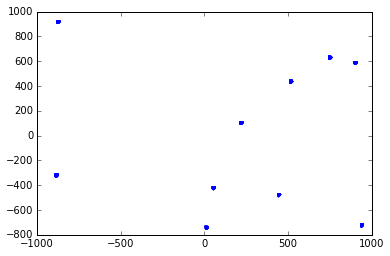

In [148]:
data,labels = generateData(1e3,2,10)

plt.plot(data[:,0],data[:,1],'.')

In [149]:
k=12
iters=100

In [189]:
#%%debug -b K_Means3.py:680
grouperCUDA = K_Means()
grouperCUDA._centroid_mode="index"
grouperCUDA.fit(data, k, iters=iters, mode="cuda", cuda_mem='manual',tol=1e-4,max_iters=300)

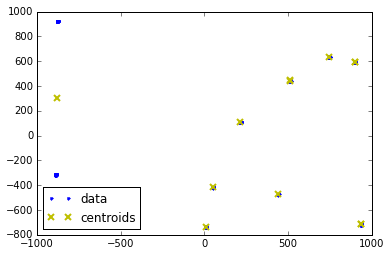

In [182]:
plt.plot(data[:,0],data[:,1],'.',label="data")
plt.plot(grouperCUDA.centroids[:,0],grouperCUDA.centroids[:,1],'yx',mew=2,label="centroids")
plt.legend(loc="best")

In [191]:
print grouperCUDA.centroids
print 'unique labels:\t', len(np.unique(grouperCUDA.labels_))
print len(grouperCUDA.partition)

[[ 215.8084259   109.30992126]
 [ 513.17559814  443.9781189 ]
 [ 215.45011902  111.23795319]
 [ 745.8984375   635.62390137]
 [ 167.34960938 -540.78851318]
 [-887.07647705 -312.77636719]
 [ 936.90045166 -715.96697998]
 [ 747.67810059  635.715271  ]
 [ 899.07055664  592.56072998]
 [-876.82330322  925.51367188]
 [ 217.24656677  110.52140045]
 [ 745.70635986  637.43292236]]
unique labels:	12
12
